In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Generating Samples

In [2]:
def generate_samples(n_samples):
    mu1 = np.array([0, 0])
    mu2 = np.array([2, 2])
    mu3 = np.array([-2, 2])

    sigma = 2
    cov = np.eye(2) * sigma

    samples = np.random.multivariate_normal(mu1, cov, n_samples//3)
    samples = np.concatenate((samples, np.random.multivariate_normal(mu2, cov, n_samples//3)))
    samples = np.concatenate((samples, np.random.multivariate_normal(mu3, cov, n_samples - (n_samples//3)*2)))
    
    return samples

Generator and Discriminator

In [3]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x
    
class Discriminator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

Train Function

In [4]:
def train(samples, n_epochs, batch_size, optimizerG, optimizerD, generator, discriminator, loss_fn):
    loss_g_list = []
    loss_d_list = []

    for epoch in range(n_epochs):

        discriminator.zero_grad()
        real_samples = samples
        real_pred = discriminator(real_samples)
        real_label = torch.ones_like(real_pred)
        real_loss = loss_fn(real_pred, real_label)
        real_loss.backward()
        optimizerD.step()

        discriminator.zero_grad()
        noise = torch.randn(batch_size, 2)
        fake_samples = generator(noise)
        fake_pred = discriminator(fake_samples)
        fake_label = torch.zeros_like(fake_pred)
        fake_loss = loss_fn(fake_pred, fake_label)
        total_loss = (real_loss.item() + fake_loss.item())/2
        loss_d = total_loss
        fake_loss.backward()
        optimizerD.step()
        
        generator.zero_grad()
        noise = torch.randn(batch_size, 2)
        fake_samples = generator(noise)
        fake_pred = discriminator(fake_samples)
        real_label = torch.ones_like(fake_pred)
        loss = loss_fn(fake_pred, real_label)
        loss_g = loss.item()
        loss.backward()
        optimizerG.step()

        print('Epoch: %d/%d, Loss_D: %.4f, Loss_G: %.4f' % (epoch+1, n_epochs, loss_d, loss_g))
        loss_g_list.append(loss_g)
        loss_d_list.append(loss_d)

    return loss_g_list, loss_d_list, generator, discriminator 

Implementing the model

Epoch: 1/2000, Loss_D: 0.7040, Loss_G: 0.6810
Epoch: 2/2000, Loss_D: 0.6886, Loss_G: 0.6800
Epoch: 3/2000, Loss_D: 0.6768, Loss_G: 0.6786
Epoch: 4/2000, Loss_D: 0.6661, Loss_G: 0.6786
Epoch: 5/2000, Loss_D: 0.6560, Loss_G: 0.6779
Epoch: 6/2000, Loss_D: 0.6461, Loss_G: 0.6778
Epoch: 7/2000, Loss_D: 0.6376, Loss_G: 0.6776
Epoch: 8/2000, Loss_D: 0.6294, Loss_G: 0.6777
Epoch: 9/2000, Loss_D: 0.6211, Loss_G: 0.6764
Epoch: 10/2000, Loss_D: 0.6135, Loss_G: 0.6762
Epoch: 11/2000, Loss_D: 0.6062, Loss_G: 0.6758
Epoch: 12/2000, Loss_D: 0.5999, Loss_G: 0.6736
Epoch: 13/2000, Loss_D: 0.5935, Loss_G: 0.6740
Epoch: 14/2000, Loss_D: 0.5878, Loss_G: 0.6753
Epoch: 15/2000, Loss_D: 0.5812, Loss_G: 0.6748
Epoch: 16/2000, Loss_D: 0.5760, Loss_G: 0.6740
Epoch: 17/2000, Loss_D: 0.5720, Loss_G: 0.6743
Epoch: 18/2000, Loss_D: 0.5666, Loss_G: 0.6746
Epoch: 19/2000, Loss_D: 0.5617, Loss_G: 0.6724
Epoch: 20/2000, Loss_D: 0.5557, Loss_G: 0.6717
Epoch: 21/2000, Loss_D: 0.5528, Loss_G: 0.6724
Epoch: 22/2000, Loss_D

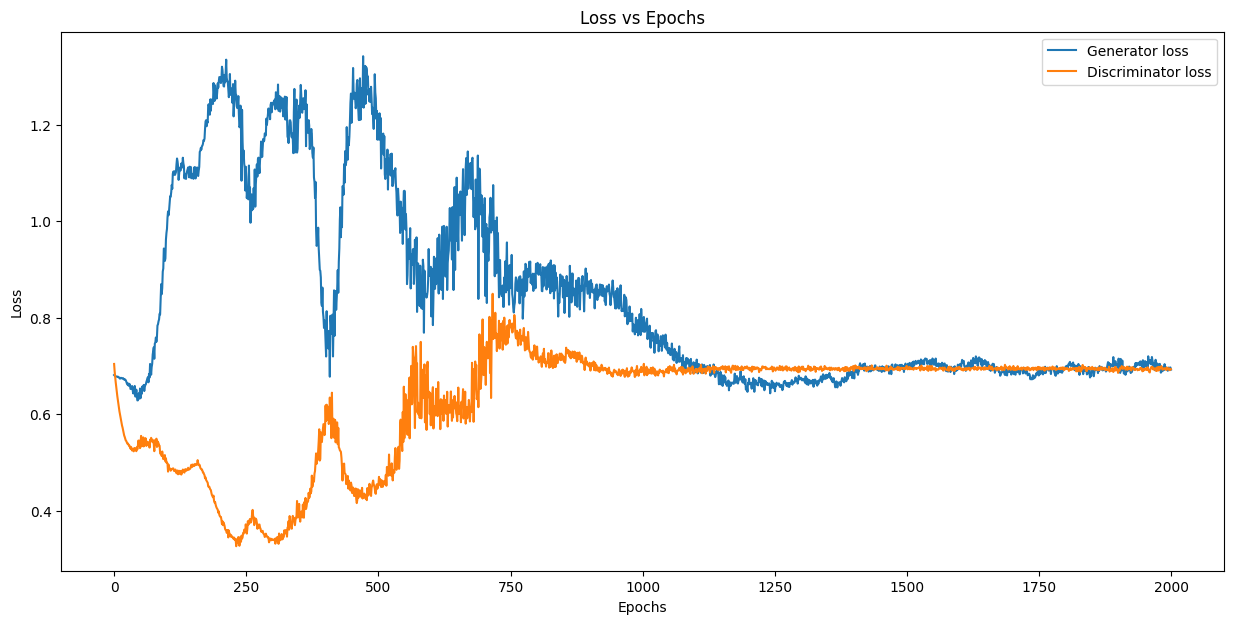

In [5]:
samples = generate_samples(10000)
samples = torch.from_numpy(samples).float()

input_dim = 2
latent_dim = 2
output_dim = 1

generator = Generator(input_dim, latent_dim)
discriminator = Discriminator(latent_dim, output_dim)

loss_fn = nn.BCELoss()
lr = 0.0002

optimizerG = optim.Adam(generator.parameters(), lr=lr)
optimizerD = optim.Adam(discriminator.parameters(), lr=lr)

n_epochs = 2000
batch_size = 64

loss_g, loss_d, generator, discriminator = train(samples, n_epochs, batch_size, optimizerG, optimizerD, generator, discriminator, loss_fn)

plt.figure(figsize=(15, 7))
plt.plot(loss_g, label='Generator loss')
plt.plot(loss_d, label='Discriminator loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

Histograms

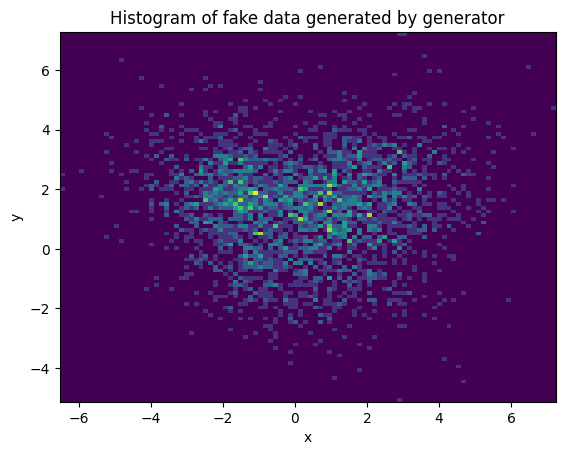

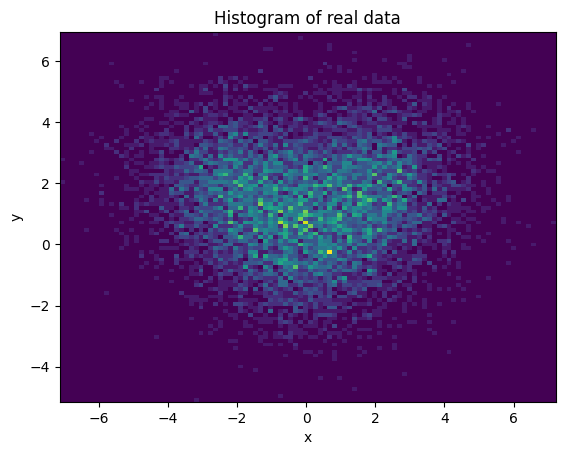

Mean of real data:  [0.22930595 1.3614339 ]


In [6]:
noise = torch.randn(3000, 2)
fake_samples = generator(noise)
fake_samples = fake_samples.detach().numpy()

plt.hist2d(fake_samples[:, 0], fake_samples[:, 1], bins=100)
plt.title('Histogram of fake data generated by generator')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

samples = samples.numpy()
plt.hist2d(samples[:, 0], samples[:, 1], bins=100)
plt.title('Histogram of real data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

print('Mean of real data: ', np.mean(fake_samples, axis=0))